# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

---

In [2]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [3]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp", 
                     "randomForest", "caretEnsemble", "MASS", "DMwR", "ROSE")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

In [4]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")
library("DMwR")
library("ROSE")


Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Warning message:
"package 'ROCR' was built under R version 3.3.2"Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.3.2"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Loading required package: lattice
Warning message:
"package 'caretEnsemble' was built under R version 3.3.2"
Attaching package: 'caretEnsemble'

The following object is masked from 'package:ggplot2':

    autoplot

Warning message:
"package 'xgboost' was built under R version 3.3.2"Warning message:
"package 'Ckmeans.1d.dp' was built under R version 3.3.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:psych':

    outlier

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'DMwR' wa

In [5]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [6]:
prostate <- read.csv("./prostate.csv")

In [7]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [8]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
2968,2968,10,1,5,7,10,9,3,5,3,10,2
1095,1095,10,3,2,2,8,5,1,5,6,1,3
693,693,2,3,8,5,5,4,7,1,4,8,0
2225,2225,4,7,10,8,2,8,10,1,6,1,1
2334,2334,2,4,2,6,4,5,8,5,1,8,3
167,167,5,8,4,8,4,1,1,4,5,4,1


In [9]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  2968 1095 693 2225 2334 167 2242 1111 373 2451 ...
 $ ATT1  : int  10 10 2 4 2 5 8 6 6 5 ...
 $ ATT2  : int  1 3 3 7 4 8 1 1 8 7 ...
 $ ATT3  : int  5 2 8 10 2 4 6 4 3 5 ...
 $ ATT4  : int  7 2 5 8 6 8 2 2 4 9 ...
 $ ATT5  : int  10 8 5 2 4 4 6 4 6 4 ...
 $ ATT6  : int  9 5 4 8 5 1 8 5 6 9 ...
 $ ATT7  : int  3 1 7 10 8 1 8 2 2 2 ...
 $ ATT8  : int  5 5 1 1 5 4 3 8 1 6 ...
 $ ATT9  : int  3 6 4 6 1 5 9 4 3 3 ...
 $ ATT10 : int  10 1 8 1 8 4 1 2 3 6 ...
 $ Result: int  2 3 0 1 3 1 0 0 1 0 ...


We can drop the ID column as it adds no benefit to our modelling

In [10]:
train$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [11]:
train$Result <- as.factor(train$Result) 

In [12]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [13]:
# Check the proportions of each factor within the Result variable in our train set
print(table(train$Result))


  0   1   2   3 
857 873 515 155 


In [14]:
# Check the proportions of each factor within the Result variable in our test set
print(table(test$Result))


  0   1   2   3 
225 207 127  41 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [15]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,2400.000,5.809,2.659,6.000,5.761,2.965,2.000,10.000,8.000,0.103,-1.178,0.054
ATT2,2.000,2400.000,4.480,2.726,4.000,4.289,2.965,1.000,10.000,9.000,0.424,-0.944,0.056
ATT3,3.000,2400.000,5.865,2.674,6.000,5.832,2.965,2.000,10.000,8.000,0.081,-1.200,0.055
ATT4,4.000,2400.000,5.860,2.647,6.000,5.825,2.965,2.000,10.000,8.000,0.067,-1.178,0.054
ATT5,5.000,2400.000,5.752,2.620,6.000,5.690,2.965,2.000,10.000,8.000,0.132,-1.121,0.053
ATT6,6.000,2400.000,4.466,2.699,4.000,4.282,2.965,1.000,10.000,9.000,0.440,-0.940,0.055
ATT7,7.000,2400.000,4.502,2.748,4.000,4.326,2.965,1.000,10.000,9.000,0.377,-1.062,0.056
ATT8,8.000,2400.000,4.469,2.720,4.000,4.281,2.965,1.000,10.000,9.000,0.394,-0.965,0.056
ATT9,9.000,2400.000,4.447,2.679,4.000,4.253,2.965,1.000,10.000,9.000,0.433,-0.886,0.055
ATT10,10.000,2400.000,4.472,2.698,4.000,4.289,2.965,1.000,10.000,9.000,0.399,-0.958,0.055


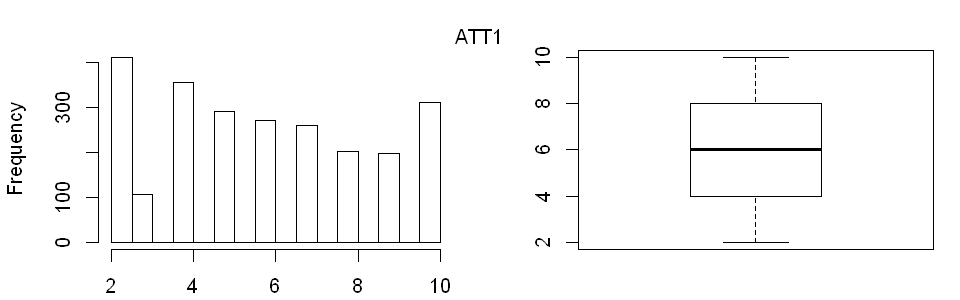

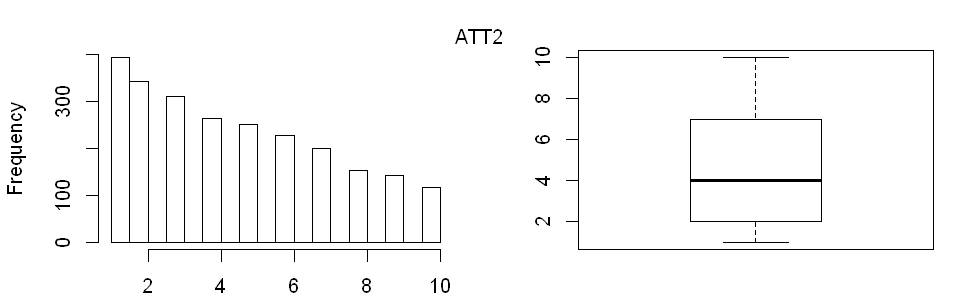

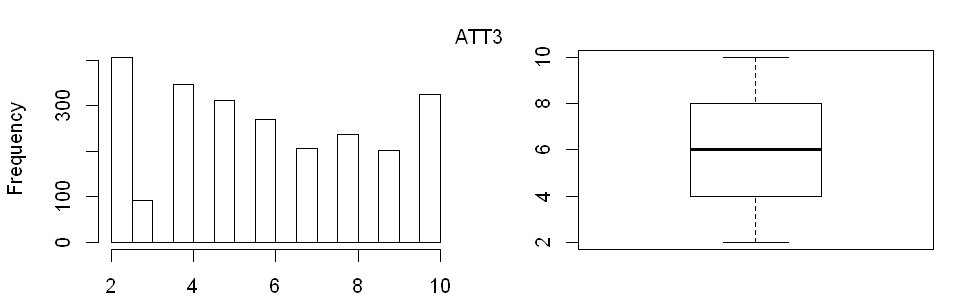

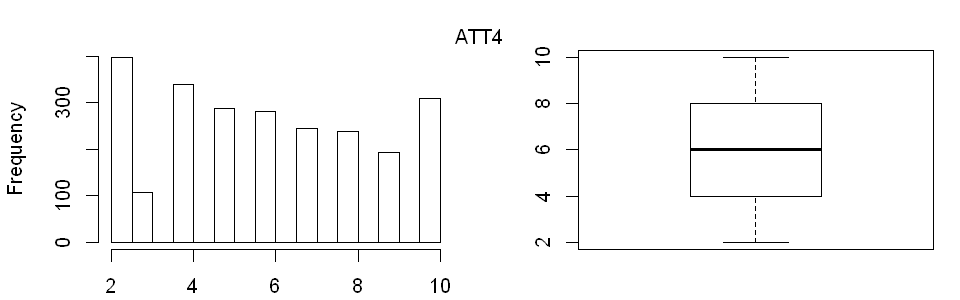

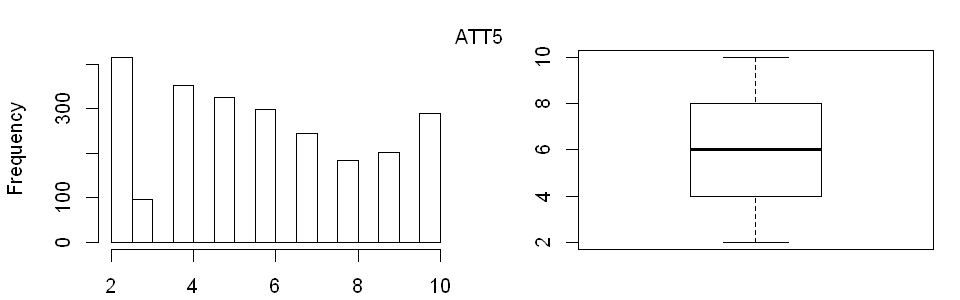

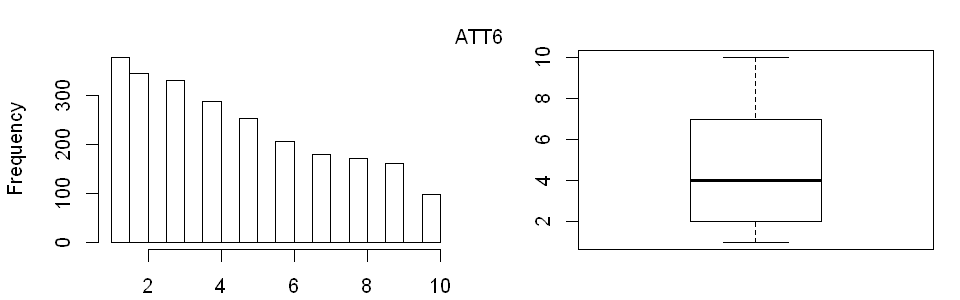

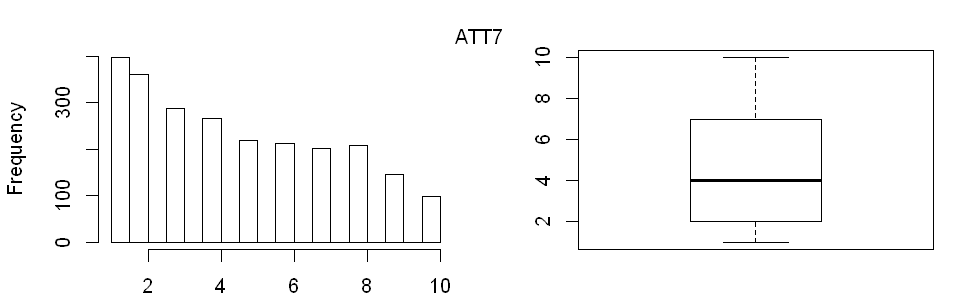

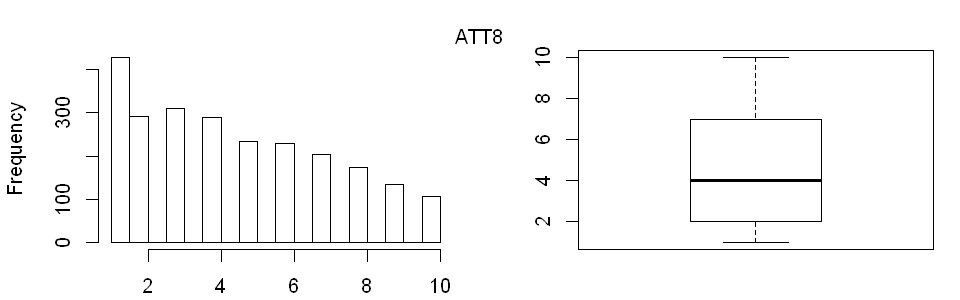

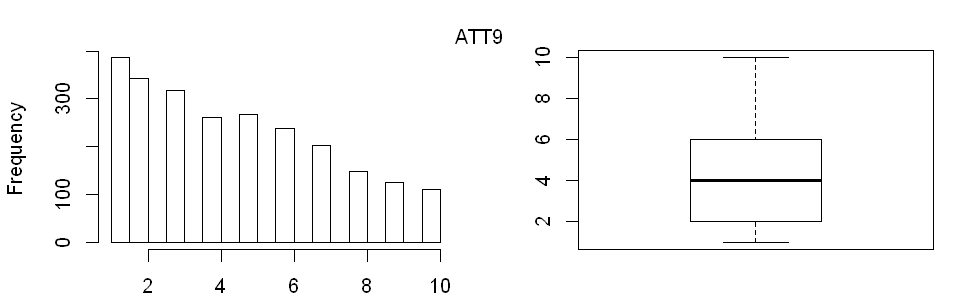

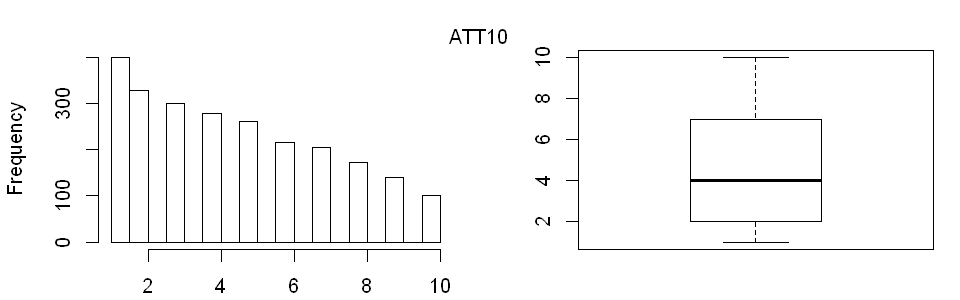

In [17]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(train)) {
    if (i != "Result") {
        hist(train[[i]],xlab=NULL,main=NULL)
        boxplot(train[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

In [ ]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

In [ ]:
ggplot(aes(x=ATT1, y=ATT2, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

In [ ]:
qplot(ATT1, ATT4, colour=Result, data=train)

# 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

---
# 3. XGBoost

In [ ]:
# perform down sampling to obtain even amount of classes
#xg_train <- Udf.Utilities.DownSample(train)
xg_train <- Udf.Utilities.UpSample(train)
#xg_train <- Udf.Utilities.SmoteSample(train)

xg_test <- test

In [ ]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w

In [ ]:
# store the actuals for future comparison
actual <- test$Result

In [ ]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [ ]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [ ]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [ ]:
# cross validate to select optimal value for number of rounds
n_rounds.cv <- 500
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 6, eta = 0.1,
               colsample_bytree = 0.9, subsample = 0.9)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

In [ ]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

In [ ]:
# create the model
bst <- xgb.train(   params              = param, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

In [ ]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [ ]:
confusionMatrix(pred, actual)

In [ ]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

In [ ]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost

# 4. Random Forest

In [ ]:
rforest_train <- Udf.Utilities.UpSample(train)
rforest <- randomForest(Result ~., data = rforest_train)

In [ ]:
rforest

In [ ]:
pred <- predict(rforest, test)

In [ ]:
confusionMatrix(pred, actual)

In [ ]:
print(importance(rforest,type = 2))

In [ ]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
#varImpPlot(rforest)

## Cross Validation for Random Forest feature selection 

In [ ]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that an 8 feature model is performing the best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [ ]:
rforest <- randomForest(Result ~ . - ATT5 - ATT1, data = rforest_train)

In [ ]:
rforest

In [ ]:
print(importance(rforest,type = 2))

In [ ]:
pred <- predict(rforest, test)

In [ ]:
confusionMatrix(pred, actual)